In [1]:
# Imports 
import os
import torch

In [2]:
from src.models import *
from src.dhand import *
from src.utils import *

In [3]:
device = torch.device('cpu')

## Data Loading

In [4]:
# Create datasets
df = read_source(
    '/home/fdi/AliBagheriNejad/Thesis/MECO/data/vib_case_dataset_ICMS Dataset.xlsx', 
    show_columns=False
)

df1,df2,dft  = double_data(
    df,
    ['VibGt_39VS4_1', 'VibGt_39VS4_2'],
    sample_length = 1024,
    overlap = 100
    
)

# files = save_to_temp_df(
#     df1,
#     df2,
#     dft,
#     dir = '/home/fdi/AliBagheriNejad/Thesis/MECO/code/TLT/temp'    
# )

In [5]:
# Read datafiles (If needed)
# df1 = pd.read_csv('/home/fdi/AliBagheriNejad/Thesis/MECO/code/TLT/temp/test_df_0.csv')
# df2 = pd.read_csv('/home/fdi/AliBagheriNejad/Thesis/MECO/code/TLT/temp/test_df_1.csv')
# df2 = pd.read_csv('/home/fdi/AliBagheriNejad/Thesis/MECO/code/TLT/temp/test_df_2.csv')

In [5]:
labels = dft.values[:,-1]
labels = np.datetime_as_string(labels, unit='D')

In [6]:
print(f'Shape of dataset 1 is {df1.shape}')
print(f'Shape of dataset 2 is {df2.shape}')
print(f'Shape of dataset time is {dft.shape}')


Shape of dataset 1 is (30, 1024)
Shape of dataset 2 is (30, 1024)
Shape of dataset time is (30, 1024)


In [49]:
from sklearn.preprocessing import StandardScaler
import joblib

In [14]:
X_scaled = np.zeros(shape=(df1.shape[0], df2.shape[1], 2))
X_scaled_self = np.zeros(shape=(df1.shape[0], df2.shape[1], 2))
df_list = [df1,df2]

s_dir = '/home/fdi/AliBagheriNejad/Thesis/MECO/code/TLT/weights/scaler'


for i in range(X_scaled.shape[2]):

    scaler = joblib.load(
        os.path.join(
            s_dir,
            f'scaler_p_mfda_01_{i}.pkl'
        )
    )

    X_scaled[:,:,i] = scaler.transform(df_list[i].values)
    X_scaled_self[:,:,i] = scaler.fit_transform(df_list[i].values)

/home/fdi/anaconda3/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.6.0 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/fdi/anaconda3/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.6.0 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Dimentionality reduction of data itself

In [25]:
from umap import UMAP

2025-02-14 20:28:35.408065: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [22]:
umap_reducer = UMAP(n_components=2, random_state=69)
embeddings = umap_reducer.fit_transform(np.nan_to_num(X_scaled).reshape(30,-1))

/home/fdi/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [41]:
from matplotlib.colors import ListedColormap
cmap = plt.get_cmap('gist_ncar')

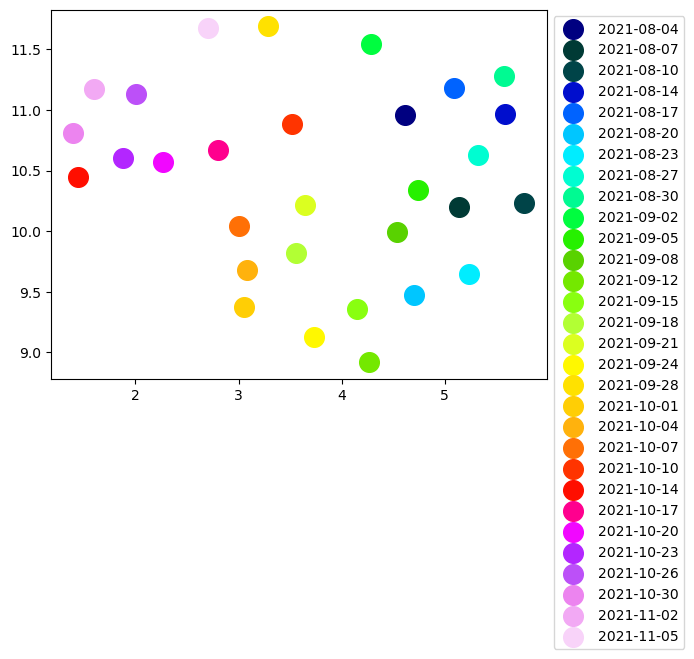

In [25]:
for i in range(np.unique(labels).shape[0]):  # Assuming 10 classes
    indices = labels == np.unique(labels)[i]
    plt.scatter(
        embeddings[indices, 0],
        embeddings[indices, 1],
        label=f'{np.unique(labels)[i]}' ,
        s=200,
        alpha=1,
        color=cmap(i/len(np.unique(labels)))
    )

plt.legend(loc='upper left', bbox_to_anchor=(1,1))

In [15]:
X_tensor = torch.tensor (X_scaled, dtype = torch.float32).to(device)
X_tensor_self = torch.tensor (X_scaled_self, dtype = torch.float32).to(device)

## Model training

In [8]:
model = Network(10,2, cons=2).to(device)

In [9]:
# Load weights
    # Mafaulda  
loaded_sd = torch.load(
        os.path.join(
            '/home/fdi/AliBagheriNejad/Thesis/MECO/code/TLT/weights',
            'mafda_test_1.pth'
        ), map_location=device
    )
del loaded_sd["conv.conv.weight"]
del loaded_sd["conv.conv.bias"]
    # CWRU
# loaded_sd = torch.load(
#         os.path.join(
#             '/home/fdi/AliBagheriNejad/Thesis/MECO/code/TLT/weights',
#             'mwdp_21.pth'
#         ), map_location=device
#     )
# loaded_sd = torch.load(
#         os.path.join(
#             '/home/fdi/AliBagheriNejad/Thesis/MECO/code/TLT/weights',
#             'cwdw_31.pth'
#         ), map_location=device
#     )

# Weight path
model.load_state_dict(loaded_sd)

/tmp/ipykernel_14887/1638825470.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_sd = torch.load(


<All keys matched successfully>

In [47]:
features_self = extract_second_features(model, X_tensor_self, device)
features = extract_second_features(model, X_tensor, device)
features_self[features_self.isnan()] = 0
features[features.isnan()] = 0

In [13]:
import umap

2025-01-20 19:25:14.044592: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [48]:
umap_reducer = umap.UMAP(n_components=2, random_state=69)
embeddings_self = umap_reducer.fit_transform(features_self)
embeddings = umap_reducer.fit_transform(features)

/home/fdi/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [21]:
# Delete datasets
# data_files = ['/home/fdi/AliBagheriNejad/Thesis/MECO/code/TLT/temp/test_df_0.csv',
#  '/home/fdi/AliBagheriNejad/Thesis/MECO/code/TLT/temp/test_df_1.csv',
#  '/home/fdi/AliBagheriNejad/Thesis/MECO/code/TLT/temp/test_df_2.csv']
# clear_files(data_files)

2025-01-20 17:33:32,536 - INFO - Deleted file: /home/fdi/AliBagheriNejad/Thesis/MECO/code/TLT/temp/test_df_0.csv
2025-01-20 17:33:32,538 - INFO - Deleted file: /home/fdi/AliBagheriNejad/Thesis/MECO/code/TLT/temp/test_df_1.csv
2025-01-20 17:33:32,539 - INFO - Deleted file: /home/fdi/AliBagheriNejad/Thesis/MECO/code/TLT/temp/test_df_2.csv
2025-01-20 17:33:32,542 - INFO - Successfully deleted 3 file(s).


3

#### mwdp weights

With overlap 100

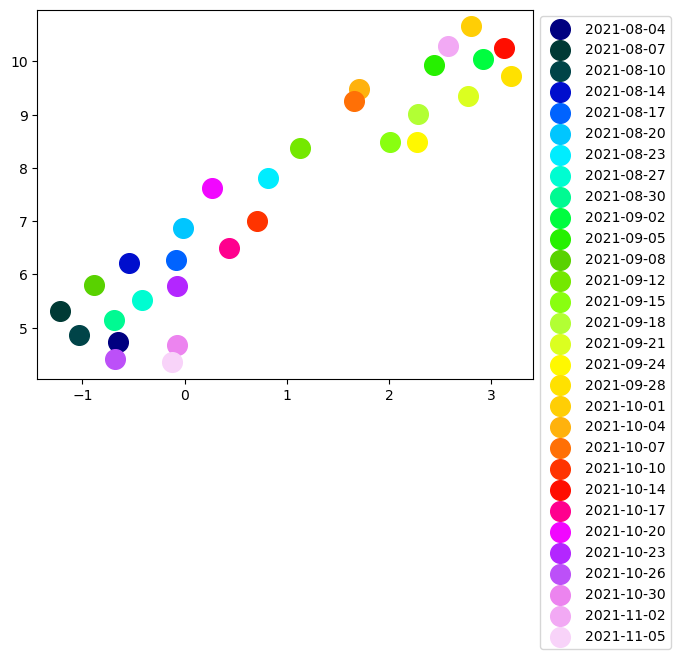

In [50]:
# Self scaled
for i in range(np.unique(labels).shape[0]):  # Assuming 10 classes
    indices = labels == np.unique(labels)[i]
    plt.scatter(
        embeddings_self[indices, 0],
        embeddings_self[indices, 1],
        label=f'{np.unique(labels)[i]}' ,
        s=200,
        alpha=1,
        color=cmap(i/len(np.unique(labels)))
    )

plt.legend(loc='upper left', bbox_to_anchor=(1,1))

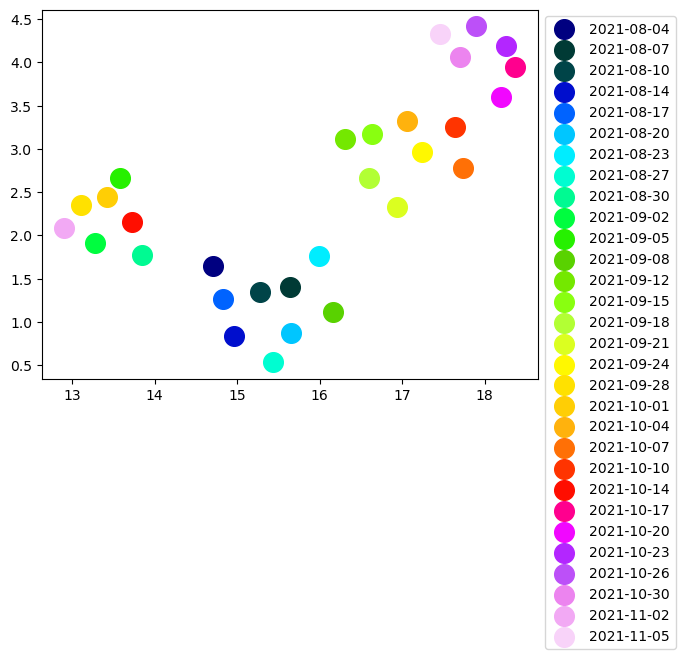

In [51]:
for i in range(np.unique(labels).shape[0]):  # Assuming 10 classes
    indices = labels == np.unique(labels)[i]
    plt.scatter(
        embeddings[indices, 0],
        embeddings[indices, 1],
        label=f'{np.unique(labels)[i]}' ,
        s=200,
        alpha=1,
        color=cmap(i/len(np.unique(labels)))
    )

plt.legend(loc='upper left', bbox_to_anchor=(1,1))

With overlap 500

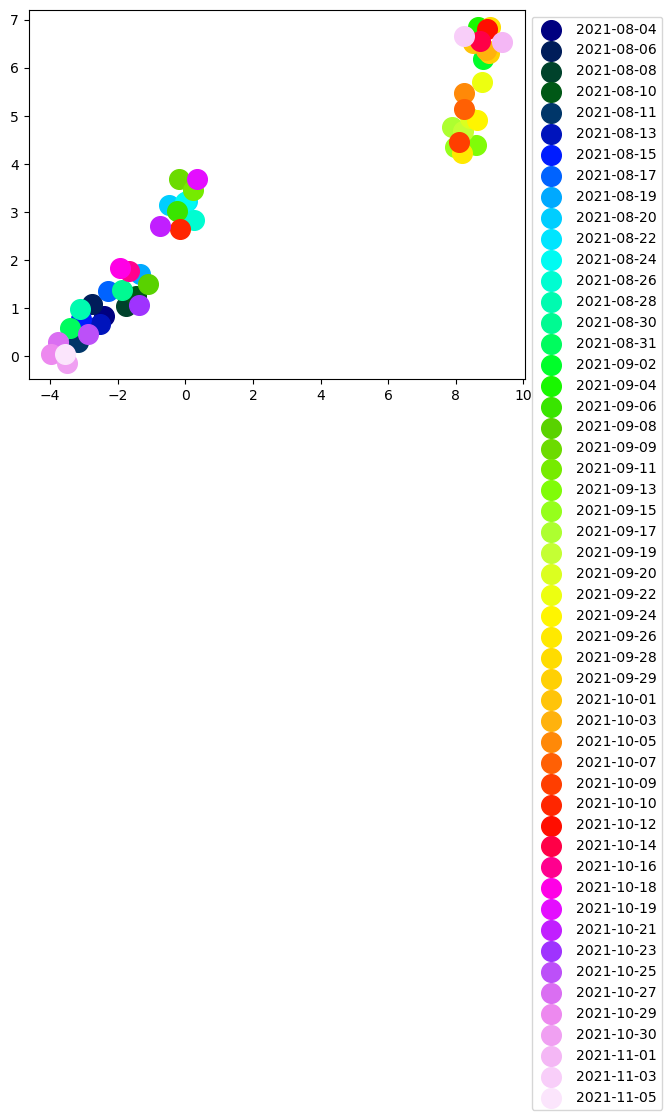

In [42]:
# Self scaled
for i in range(np.unique(labels).shape[0]):  # Assuming 10 classes
    indices = labels == np.unique(labels)[i]
    plt.scatter(
        embeddings_self[indices, 0],
        embeddings_self[indices, 1],
        label=f'{np.unique(labels)[i]}' ,
        s=200,
        alpha=1,
        color=cmap(i/len(np.unique(labels)))
    )

plt.legend(loc='upper left', bbox_to_anchor=(1,1))

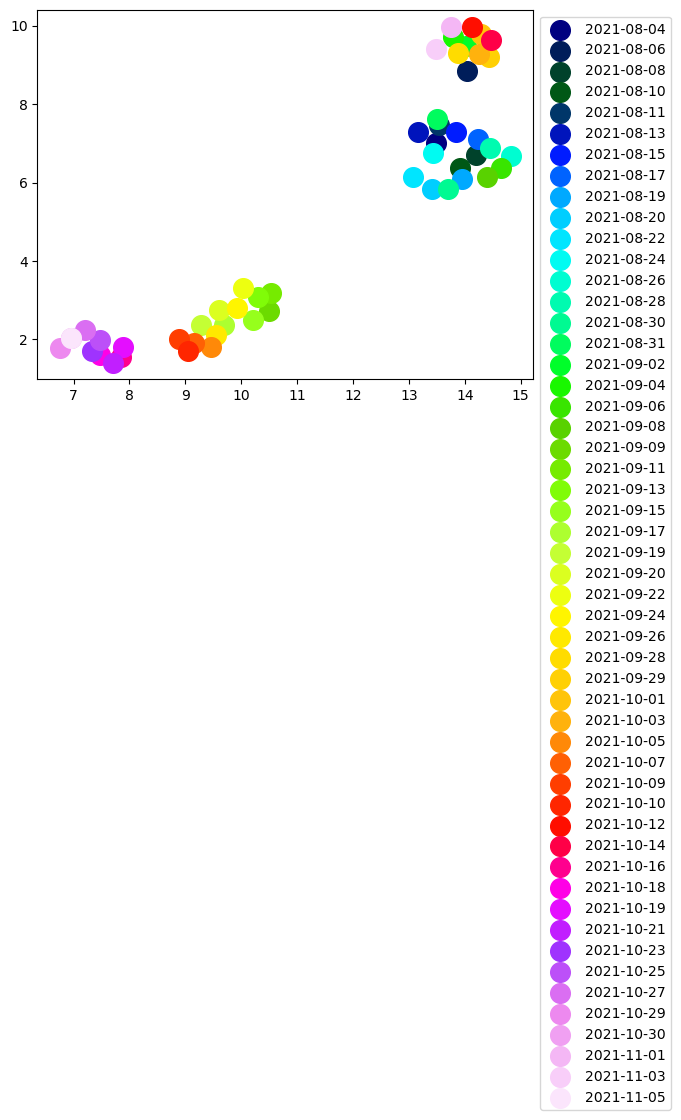

In [43]:
for i in range(np.unique(labels).shape[0]):  # Assuming 10 classes
    indices = labels == np.unique(labels)[i]
    plt.scatter(
        embeddings[indices, 0],
        embeddings[indices, 1],
        label=f'{np.unique(labels)[i]}' ,
        s=200,
        alpha=1,
        color=cmap(i/len(np.unique(labels)))
    )

plt.legend(loc='upper left', bbox_to_anchor=(1,1))

#### cwdw weights

With overlap 500

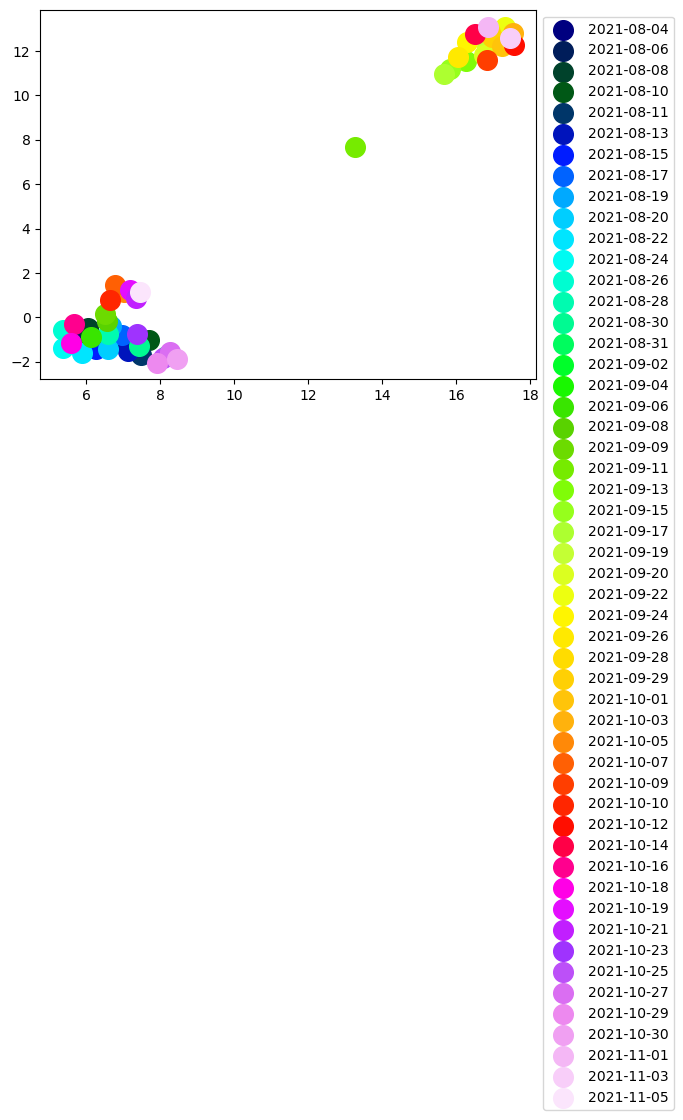

In [33]:
# Self scaled
for i in range(np.unique(labels).shape[0]):  # Assuming 10 classes
    indices = labels == np.unique(labels)[i]
    plt.scatter(
        embeddings_self[indices, 0],
        embeddings_self[indices, 1],
        label=f'{np.unique(labels)[i]}' ,
        s=200,
        alpha=1,
        color=cmap(i/len(np.unique(labels)))
    )

plt.legend(loc='upper left', bbox_to_anchor=(1,1))

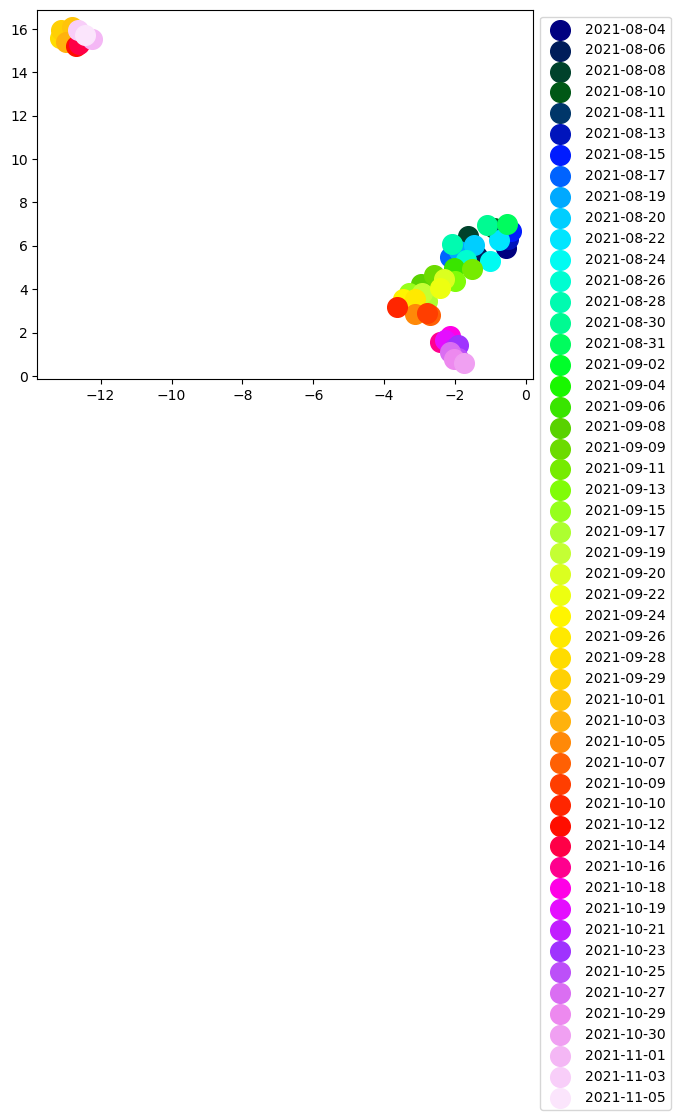

In [34]:
for i in range(np.unique(labels).shape[0]):  # Assuming 10 classes
    indices = labels == np.unique(labels)[i]
    plt.scatter(
        embeddings[indices, 0],
        embeddings[indices, 1],
        label=f'{np.unique(labels)[i]}' ,
        s=200,
        alpha=1,
        color=cmap(i/len(np.unique(labels)))
    )

plt.legend(loc='upper left', bbox_to_anchor=(1,1))

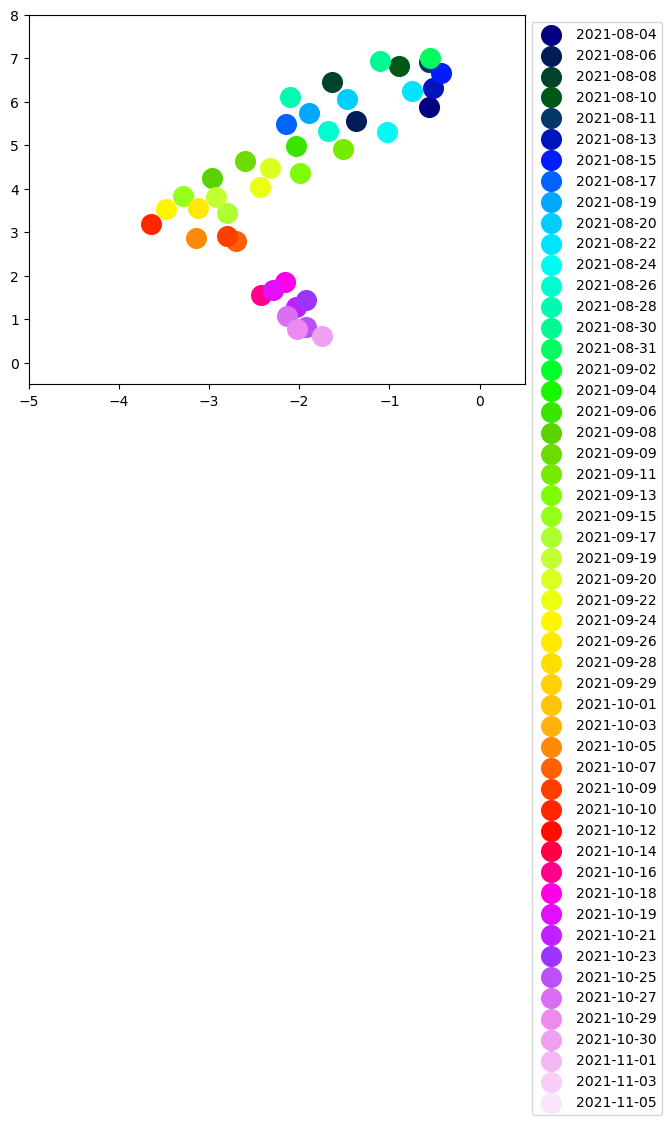

In [37]:
for i in range(np.unique(labels).shape[0]):  # Assuming 10 classes
    indices = labels == np.unique(labels)[i]
    plt.scatter(
        embeddings[indices, 0],
        embeddings[indices, 1],
        label=f'{np.unique(labels)[i]}' ,
        s=200,
        alpha=1,
        color=cmap(i/len(np.unique(labels)))
    )

plt.xlim((-5,0.5))
plt.ylim((-0.5, 8))
plt.legend(loc='upper left', bbox_to_anchor=(1,1))

With overlap 100

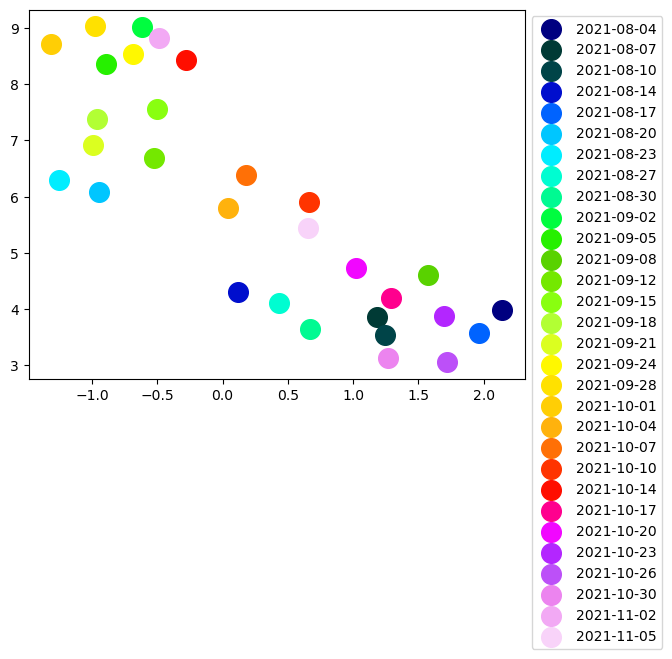

In [17]:
# Self scaled
for i in range(np.unique(labels).shape[0]):  # Assuming 10 classes
    indices = labels == np.unique(labels)[i]
    plt.scatter(
        embeddings_self[indices, 0],
        embeddings_self[indices, 1],
        label=f'{np.unique(labels)[i]}' ,
        s=200,
        alpha=1,
        color=cmap(i/len(np.unique(labels)))
    )

plt.legend(loc='upper left', bbox_to_anchor=(1,1))

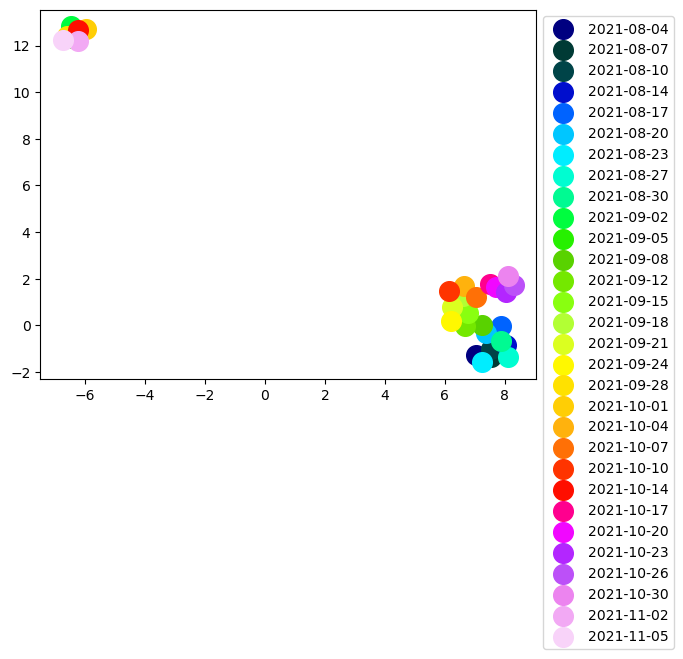

In [18]:
for i in range(np.unique(labels).shape[0]):  # Assuming 10 classes
    indices = labels == np.unique(labels)[i]
    plt.scatter(
        embeddings[indices, 0],
        embeddings[indices, 1],
        label=f'{np.unique(labels)[i]}' ,
        s=200,
        alpha=1,
        color=cmap(i/len(np.unique(labels)))
    )

plt.legend(loc='upper left', bbox_to_anchor=(1,1))

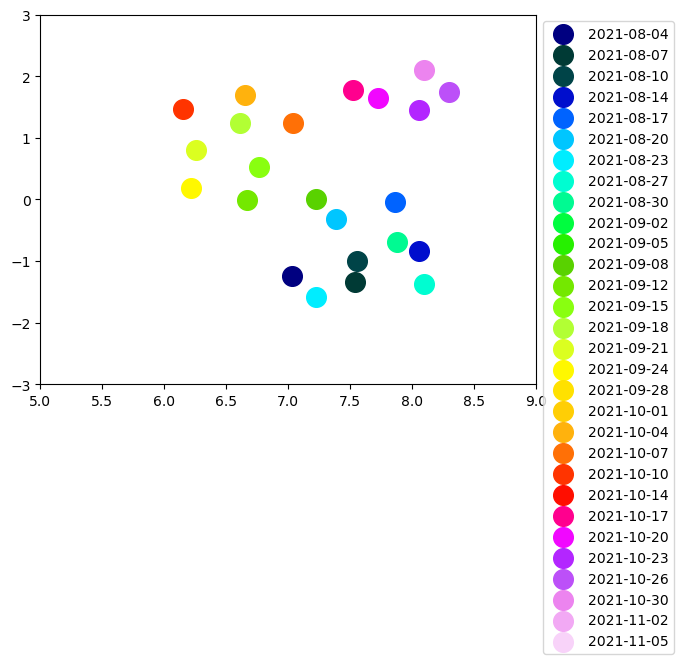

In [19]:
for i in range(np.unique(labels).shape[0]):  # Assuming 10 classes
    indices = labels == np.unique(labels)[i]
    plt.scatter(
        embeddings[indices, 0],
        embeddings[indices, 1],
        label=f'{np.unique(labels)[i]}' ,
        s=200,
        alpha=1,
        color=cmap(i/len(np.unique(labels)))
    )

plt.xlim((5,9))
plt.ylim((-3,3))
plt.legend(loc='upper left', bbox_to_anchor=(1,1))

#### ICMS (2021)

With 100 overlap

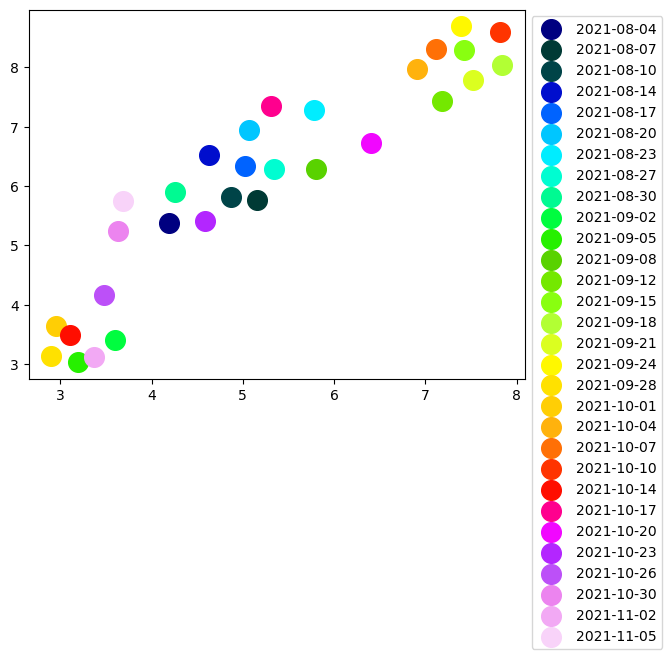

In [29]:
# Self scaled
for i in range(np.unique(labels).shape[0]):  # Assuming 10 classes
    indices = labels == np.unique(labels)[i]
    plt.scatter(
        embeddings_self[indices, 0],
        embeddings_self[indices, 1],
        label=f'{np.unique(labels)[i]}' ,
        s=200,
        alpha=1,
        color=cmap(i/len(np.unique(labels)))
    )

plt.legend(loc='upper left', bbox_to_anchor=(1,1))

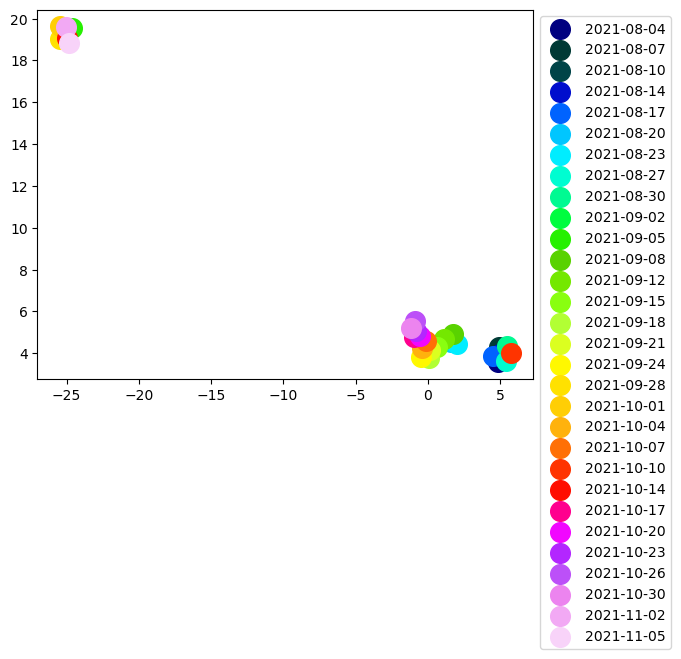

In [30]:
for i in range(np.unique(labels).shape[0]):  # Assuming 10 classes
    indices = labels == np.unique(labels)[i]
    plt.scatter(
        embeddings[indices, 0],
        embeddings[indices, 1],
        label=f'{np.unique(labels)[i]}' ,
        s=200,
        alpha=1,
        color=cmap(i/len(np.unique(labels)))
    )

plt.legend(loc='upper left', bbox_to_anchor=(1,1))

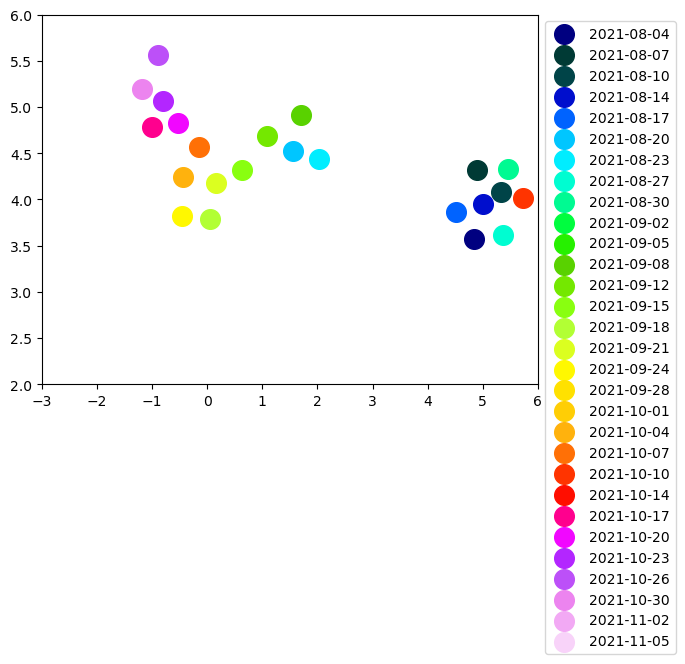

In [31]:
for i in range(np.unique(labels).shape[0]):  # Assuming 10 classes
    indices = labels == np.unique(labels)[i]
    plt.scatter(
        embeddings[indices, 0],
        embeddings[indices, 1],
        label=f'{np.unique(labels)[i]}' ,
        s=200,
        alpha=1,
        color=cmap(i/len(np.unique(labels)))
    )

plt.xlim((-3,6))
plt.ylim((2,6))
plt.legend(loc='upper left', bbox_to_anchor=(1,1))

With 500 overlap

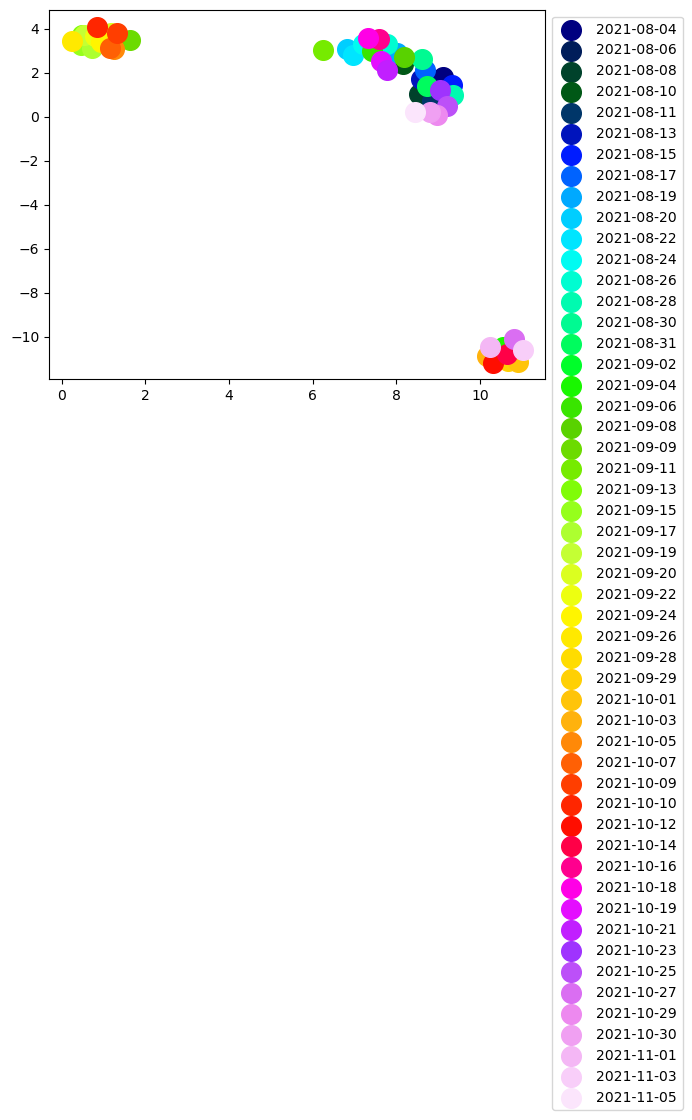

In [19]:
# Self scaled
for i in range(np.unique(labels).shape[0]):  # Assuming 10 classes
    indices = labels == np.unique(labels)[i]
    plt.scatter(
        embeddings_self[indices, 0],
        embeddings_self[indices, 1],
        label=f'{np.unique(labels)[i]}' ,
        s=200,
        alpha=1,
        color=cmap(i/len(np.unique(labels)))
    )

plt.legend(loc='upper left', bbox_to_anchor=(1,1))

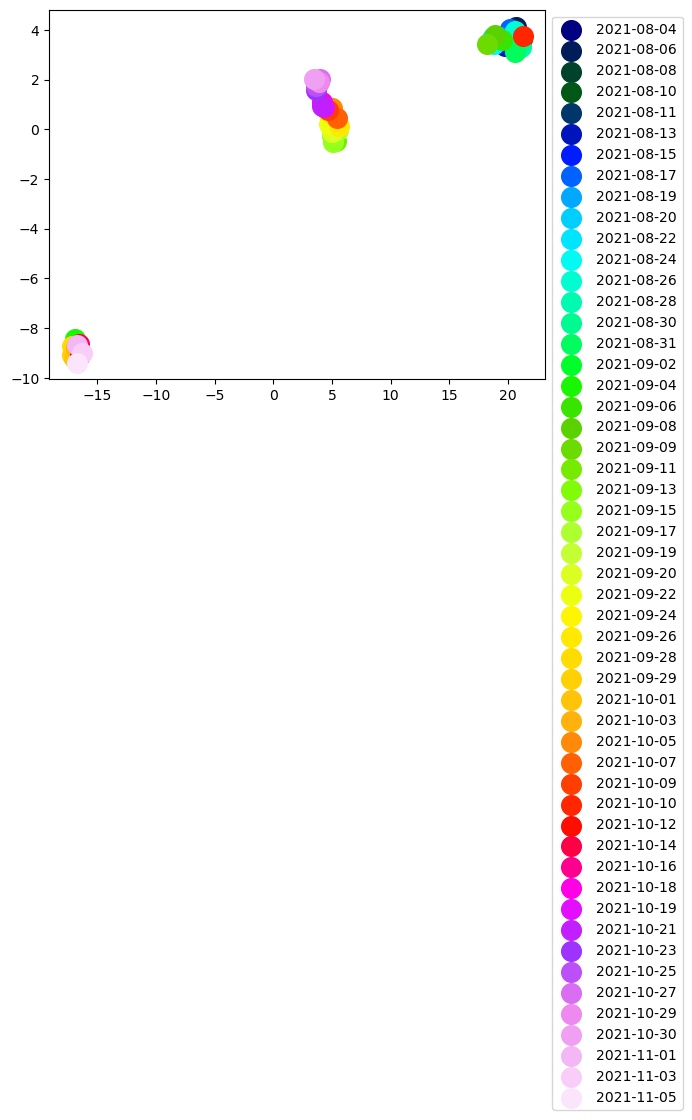

In [20]:
for i in range(np.unique(labels).shape[0]):  # Assuming 10 classes
    indices = labels == np.unique(labels)[i]
    plt.scatter(
        embeddings[indices, 0],
        embeddings[indices, 1],
        label=f'{np.unique(labels)[i]}' ,
        s=200,
        alpha=1,
        color=cmap(i/len(np.unique(labels)))
    )

plt.legend(loc='upper left', bbox_to_anchor=(1,1))

With no overlap

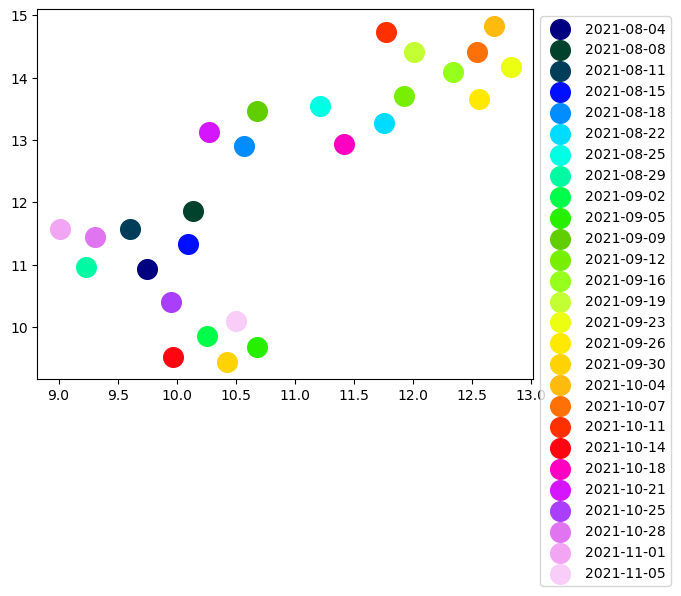

In [ ]:
# Self scaled
for i in range(np.unique(labels).shape[0]):  # Assuming 10 classes
    indices = labels == np.unique(labels)[i]
    plt.scatter(
        embeddings_self[indices, 0],
        embeddings_self[indices, 1],
        label=f'{np.unique(labels)[i]}' ,
        s=200,
        alpha=1,
        color=cmap(i/len(np.unique(labels)))
    )

plt.legend(loc='upper left', bbox_to_anchor=(1,1))

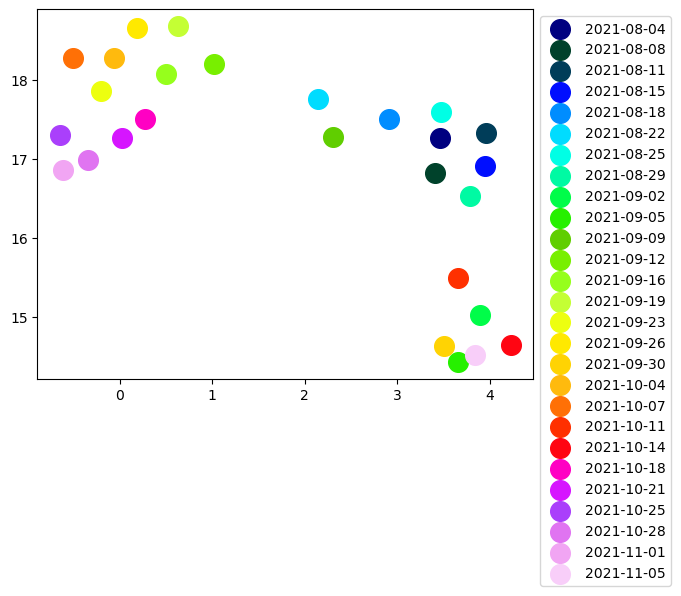

In [35]:
for i in range(np.unique(labels).shape[0]):  # Assuming 10 classes
    indices = labels == np.unique(labels)[i]
    plt.scatter(
        embeddings[indices, 0],
        embeddings[indices, 1],
        label=f'{np.unique(labels)[i]}' ,
        s=200,
        alpha=1,
        color=cmap(i/len(np.unique(labels)))
    )

plt.legend(loc='upper left', bbox_to_anchor=(1,1))

## MaFaulDa (proposed)

In [37]:
model = Network(10,2, cons=2).to(device)
# Load weights
    # Mafaulda  
loaded_sd = torch.load(
        os.path.join(
            '/home/fdi/AliBagheriNejad/Thesis/MECO/code/TLT/weights',
            'mafda_test_2.pth'
        ), map_location=device
    )
del loaded_sd["conv.conv.weight"]
del loaded_sd["conv.conv.bias"]
    # CWRU
# loaded_sd = torch.load(
#         os.path.join(
#             '/home/fdi/AliBagheriNejad/Thesis/MECO/code/TLT/weights',
#             'mwdp_21.pth'
#         ), map_location=device
#     )
# loaded_sd = torch.load(
#         os.path.join(
#             '/home/fdi/AliBagheriNejad/Thesis/MECO/code/TLT/weights',
#             'cwdw_31.pth'
#         ), map_location=device
#     )

# Weight path
model.load_state_dict(loaded_sd)
features_self = extract_second_features(model, X_tensor_self, device)
features = extract_second_features(model, X_tensor, device)
features_self[features_self.isnan()] = 0
features[features.isnan()] = 0


/tmp/ipykernel_7129/4099557869.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_sd = torch.load(


/home/fdi/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


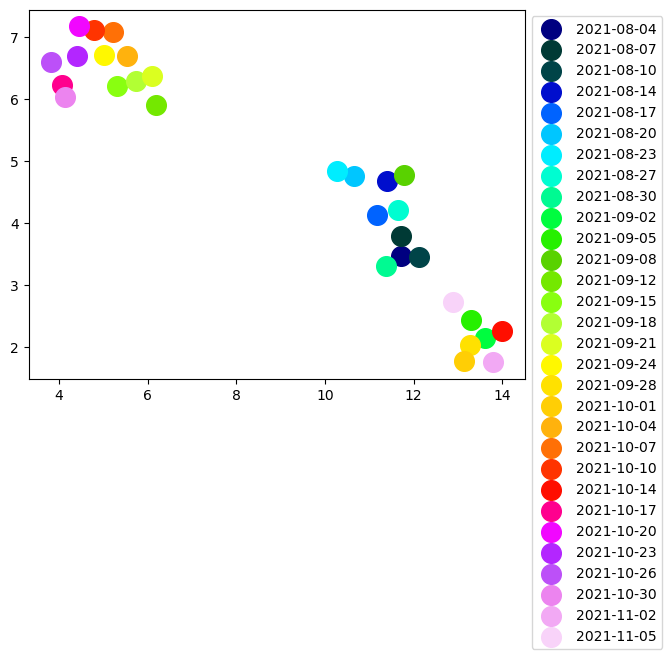

In [39]:

umap_reducer = UMAP(n_components=2, random_state=69, n_neighbors=12)
embeddings_self = umap_reducer.fit_transform(features_self)
embeddings = umap_reducer.fit_transform(features)

for i in range(np.unique(labels).shape[0]):  # Assuming 10 classes
    indices = labels == np.unique(labels)[i]
    plt.scatter(
        embeddings[indices, 0],
        embeddings[indices, 1],
        label=f'{np.unique(labels)[i]}' ,
        s=200,
        alpha=1,
        color=cmap(i/len(np.unique(labels)))
    )

plt.legend(loc='upper left', bbox_to_anchor=(1,1))

## MaFaulDa (Usual)

In [22]:
model = NetworkNoReg(10,2).to(device)
# Load weights
    # Mafaulda  
loaded_sd = torch.load(
        os.path.join(
            '/home/fdi/AliBagheriNejad/Thesis/MECO/code/TLT/weights',
            'mafda_noreg_2.pth'
        ), map_location=device
    )
del loaded_sd["conv.conv.weight"]
del loaded_sd["conv.conv.bias"]
    # CWRU
# loaded_sd = torch.load(
#         os.path.join(
#             '/home/fdi/AliBagheriNejad/Thesis/MECO/code/TLT/weights',
#             'mwdp_21.pth'
#         ), map_location=device
#     )
# loaded_sd = torch.load(
#         os.path.join(
#             '/home/fdi/AliBagheriNejad/Thesis/MECO/code/TLT/weights',
#             'cwdw_31.pth'
#         ), map_location=device
#     )

# Weight path
model.load_state_dict(loaded_sd)
features = extract_features(model, X_tensor, device)
features[features.isnan()] = 0


/tmp/ipykernel_7129/2397059451.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_sd = torch.load(


/home/fdi/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


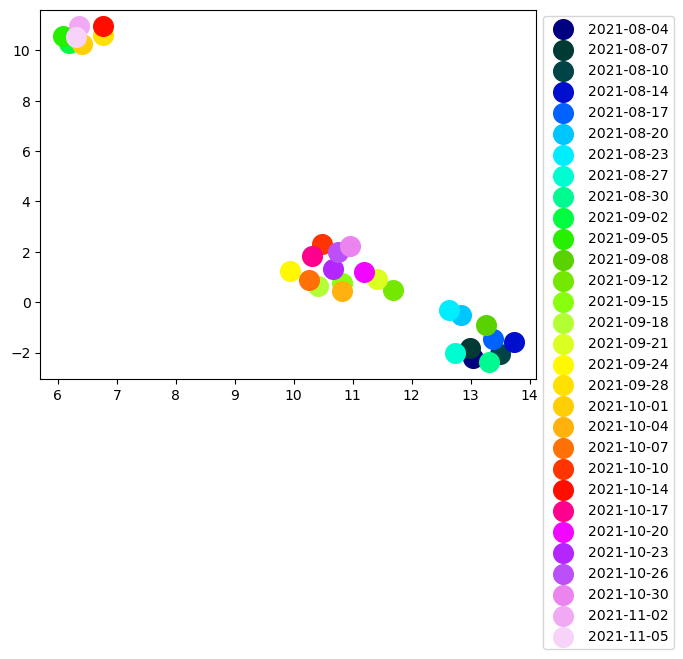

In [36]:

umap_reducer = UMAP(n_components=2, random_state=69,n_neighbors=13)
embeddings = umap_reducer.fit_transform(features)

for i in range(np.unique(labels).shape[0]):  # Assuming 10 classes
    indices = labels == np.unique(labels)[i]
    plt.scatter(
        embeddings[indices, 0],
        embeddings[indices, 1],
        label=f'{np.unique(labels)[i]}' ,
        s=200,
        alpha=1,
        color=cmap(i/len(np.unique(labels)))
    )

plt.legend(loc='upper left', bbox_to_anchor=(1,1))

In [35]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [18]:
# Initialize PCA with 2 components
pca_reducer = PCA(n_components=2, random_state=69)

# Fit and transform the features
embeddings = pca_reducer.fit_transform(features)

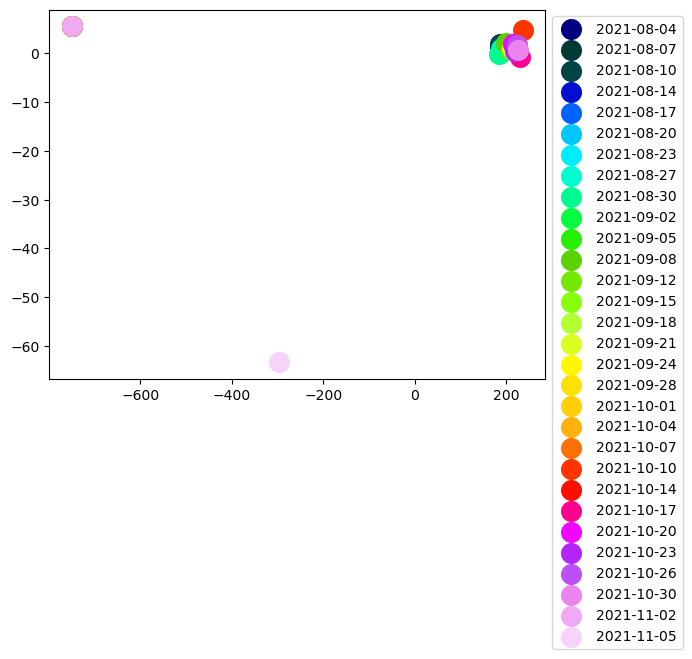

In [21]:
for i in range(np.unique(labels).shape[0]):  # Assuming 10 classes
    indices = labels == np.unique(labels)[i]
    plt.scatter(
        embeddings[indices, 0],
        embeddings[indices, 1],
        label=f'{np.unique(labels)[i]}' ,
        s=200,
        alpha=1,
        color=cmap(i/len(np.unique(labels)))
    )
# plt.xlim((100, 300))
# plt.ylim((-10, 10))
plt.legend(loc='upper left', bbox_to_anchor=(1,1))

## new way

Our model

In [23]:
model.eval()

a = model(X_tensor)
_,a = torch.max(a,1)
a = a.cpu().detach().numpy()

In [24]:
print(a)

[7 7 7 7 7 7 7 7 7 0 0 7 7 7 7 7 7 0 0 7 7 7 0 7 7 7 7 7 0 7]


usual model

In [25]:
model = NetworkNoReg(10,2).to(device)
# Load weights
    # Mafaulda  
loaded_sd = torch.load(
        os.path.join(
            '/home/fdi/AliBagheriNejad/Thesis/MECO/code/TLT/weights',
            'mafda_noreg_2.pth'
        ), map_location=device
    )
del loaded_sd["conv.conv.weight"]
del loaded_sd["conv.conv.bias"]
    # CWRU
# loaded_sd = torch.load(
#         os.path.join(
#             '/home/fdi/AliBagheriNejad/Thesis/MECO/code/TLT/weights',
#             'mwdp_21.pth'
#         ), map_location=device
#     )
# loaded_sd = torch.load(
#         os.path.join(
#             '/home/fdi/AliBagheriNejad/Thesis/MECO/code/TLT/weights',
#             'cwdw_31.pth'
#         ), map_location=device
#     )

# Weight path
model.load_state_dict(loaded_sd)
features = extract_features(model, X_tensor, device)
features[features.isnan()] = 0

/tmp/ipykernel_14887/3605259658.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_sd = torch.load(


In [26]:
model.eval()

a = model(X_tensor)
_,a = torch.max(a,1)
a = a.cpu().detach().numpy()

In [27]:
print(a)

[7 7 7 7 7 7 7 7 7 0 0 7 7 7 7 7 7 0 0 7 7 7 0 7 7 7 7 7 0 7]


## Trick 2 (gen data)

### Generating data

In [62]:
total_length = 100000
x = np.linspace(0,10,total_length)
ch_1 = np.sin(x*100)*2
ch_2 = np.cos(x*100)*2

np.random.seed(69)
noise_1 = np.random.rand(total_length,)
noise_1 -= np.mean(noise_1)
np.random.seed(85)
noise_2 = np.random.rand(total_length,)
noise_2 -= np.mean(noise_2)

In [63]:
ch_1_f1 = ch_1 + noise_1
ch_2_f2 = ch_2 + noise_2

In [64]:
df_ch1 = create_dataset(pd.Series(ch_1), 1024, 0)
df_ch2 = create_dataset(pd.Series(ch_2), 1024, 0)
df_ch1f = create_dataset(pd.Series(ch_1_f1), 1024, 0)
df_ch2f = create_dataset(pd.Series(ch_2_f2), 1024, 0)

In [65]:
cl_1 = np.zeros(shape = (df_ch1.shape[0],df_ch1.shape[1],2))
cl_2 = np.zeros(shape = (df_ch1.shape[0],df_ch1.shape[1],2))
cl_3 = np.zeros(shape = (df_ch1.shape[0],df_ch1.shape[1],2))

cl_1[:,:,0] = df_ch1
cl_1[:,:,1] = df_ch2
cl_2[:,:,0] = df_ch1f
cl_2[:,:,1] = df_ch2
cl_3[:,:,0] = df_ch1
cl_3[:,:,1] = df_ch2f

X_gen = np.concatenate([cl_1, cl_2, cl_3], axis=0)

label_1 = np.zeros(cl_1.shape[0],)
label_2 = np.ones(cl_2.shape[0],)
label_3 = np.ones(cl_3.shape[0],)*2

y_gen = np.hstack((label_1,label_2, label_3))

In [66]:
s_dir = '/home/fdi/AliBagheriNejad/Thesis/MECO/code/TLT/weights/scaler'
X_scaled = np.zeros_like(X_gen)

for i in range(X_gen.shape[2]):

    scaler = joblib.load(
        os.path.join(
            s_dir,
            f'scaler_p_mfda_01_{i}.pkl'
        )
    )

    X_scaled[:,:,i] = scaler.transform(X_gen[:,:,i])

/home/fdi/anaconda3/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.6.0 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/fdi/anaconda3/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.6.0 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [67]:
X_tensor = torch.tensor(X_scaled, dtype=torch.float32).to(device)
y_gen = torch.tensor(y_gen, dtype=torch.int8).to(device)

In [68]:
model_1 = Network(10,2,cons=2).to(device)
loaded_sd = torch.load(
        os.path.join(
            '/home/fdi/AliBagheriNejad/Thesis/MECO/code/TLT/weights',
            'mafda_test_1.pth'
        ), map_location=device
    )
del loaded_sd["conv.conv.weight"]
del loaded_sd["conv.conv.bias"]
model_1.load_state_dict(loaded_sd)

model_2 = NetworkNoReg(10,2).to(device)
loaded_sd = torch.load(
        os.path.join(
            '/home/fdi/AliBagheriNejad/Thesis/MECO/code/TLT/weights',
            'mafda_noreg_2.pth'
        ), map_location=device
    )
del loaded_sd["conv.conv.weight"]
del loaded_sd["conv.conv.bias"]
model_2.load_state_dict(loaded_sd)

/tmp/ipykernel_17847/2963483970.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_sd = torch.load(
/tmp/ipykernel_17847/2963483970.py:13: FutureWarning: You are usi

<All keys matched successfully>

In [69]:
model_1.eval()
model_2.eval()

feat_1 = extract_second_features(model_1, X_tensor, device)
feat_2 = extract_features(model_2, X_tensor, device)

/home/fdi/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/fdi/anaconda3/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:455: UserWarning: Exited at iteration 2000 with accuracies 
[6.19777941e-14 9.42443031e-08 6.50216419e-07 1.30516097e-05]
not reaching the requested tolerance 9.08970832824707e-07.
Use iteration 1809 instead with accuracy 
1.1068803088103667e-06.

  _, diffusion_map = lobpcg(
/home/fdi/anaconda3/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:455: UserWarning: Exited postprocessing with accuracies 
[5.34758817e-15 8.42268311e-08 3.23580247e-07 4.01971610e-06]
not reaching the requested tolerance 9.08970832824707e-07.
  _, diffusion_map = lobpcg(
/home/fdi/anaconda3/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:455: UserWarning: Exited at iteration 2000 with accuracies 
[5.84517597e-1

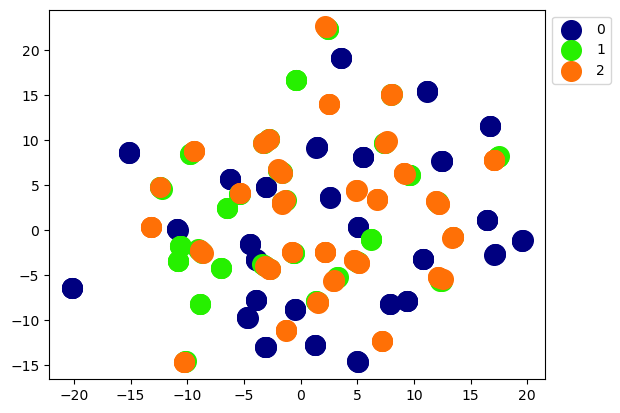

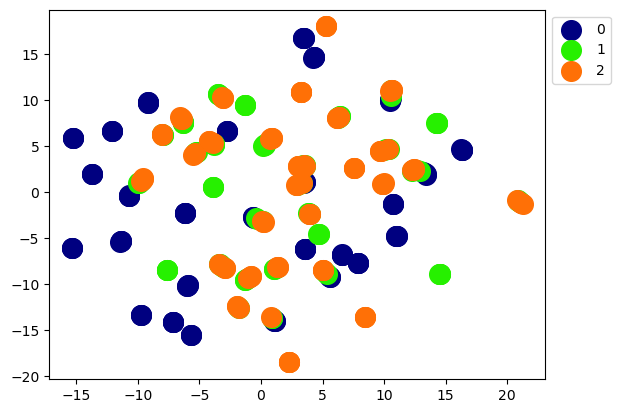

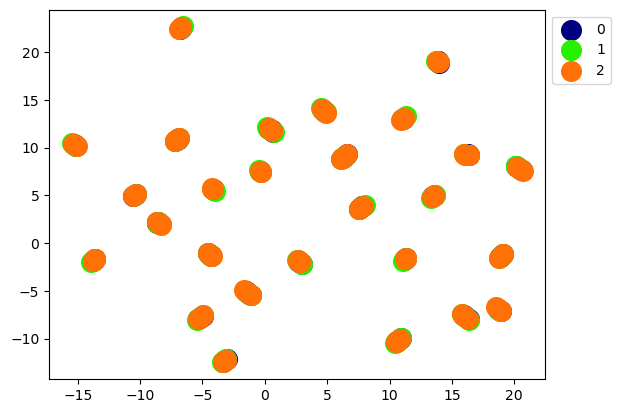

In [70]:
umap_reducer = UMAP(n_components=2, random_state=69, n_neighbors=3)
embeddings_1 = umap_reducer.fit_transform(feat_1)
embeddings_2 = umap_reducer.fit_transform(feat_2)
embeddings_3 = umap_reducer.fit_transform(X_tensor.cpu().detach().numpy().reshape(97*3,-1))
labels = y_gen

ems = [embeddings_1, embeddings_2, embeddings_3]

for p in ems:
    embeddings = p
    plt.figure()
    for i in range(np.unique(labels).shape[0]):  # Assuming 10 classes
        indices = labels == np.unique(labels)[i]
        plt.scatter(
            embeddings[indices, 0],
            embeddings[indices, 1],
            label=f'{np.unique(labels)[i]}' ,
            s=200,
            alpha=1,
            color=cmap(i/len(np.unique(labels)))
        )

    plt.legend(loc='upper left', bbox_to_anchor=(1,1))

In [ ]:
from sklean.manifold import TSNE # show them with TSNE

ModuleNotFoundError: No module named 'sklean'

In [71]:
a_1 = model_1(X_tensor)
a_2 = model_2(X_tensor)
_,a_1 = torch.max(a_1,1)
_,a_2 = torch.max(a_2,1)
a_1 = a_1.cpu().detach().numpy()
a_2 = a_2.cpu().detach().numpy()

a_1, a_2

(array([3, 3, 6, 3, 6, 6, 3, 6, 3, 3, 6, 3, 3, 6, 3, 6, 3, 3, 6, 3, 3, 6,
        3, 6, 6, 3, 6, 3, 3, 6, 3, 3, 6, 3, 6, 3, 3, 6, 3, 3, 6, 3, 6, 3,
        3, 6, 3, 3, 6, 3, 6, 6, 3, 6, 3, 3, 6, 3, 3, 6, 3, 6, 3, 3, 6, 3,
        3, 6, 3, 6, 3, 3, 6, 3, 3, 6, 3, 6, 6, 3, 6, 3, 3, 6, 3, 3, 6, 3,
        6, 3, 3, 6, 3, 3, 6, 3, 6, 3, 3, 6, 3, 6, 6, 3, 6, 6, 3, 6, 3, 3,
        6, 3, 6, 6, 3, 6, 3, 3, 6, 3, 6, 6, 3, 6, 3, 3, 6, 3, 6, 6, 3, 6,
        6, 3, 6, 3, 3, 6, 3, 6, 6, 3, 6, 3, 3, 6, 3, 6, 6, 3, 6, 3, 3, 6,
        3, 6, 6, 3, 6, 6, 3, 6, 3, 3, 6, 3, 6, 6, 3, 6, 3, 3, 6, 3, 6, 6,
        3, 6, 6, 3, 6, 3, 3, 6, 3, 6, 6, 3, 6, 3, 3, 6, 3, 6, 3, 3, 6, 3,
        6, 6, 3, 6, 6, 3, 6, 3, 3, 6, 3, 6, 6, 3, 6, 3, 3, 6, 3, 6, 6, 3,
        6, 6, 3, 6, 3, 6, 6, 3, 6, 6, 3, 6, 3, 3, 6, 3, 6, 6, 3, 6, 3, 3,
        6, 3, 6, 6, 3, 6, 6, 3, 6, 3, 6, 6, 3, 6, 6, 3, 6, 3, 3, 6, 3, 6,
        6, 3, 6, 3, 3, 6, 3, 6, 6, 3, 6, 6, 3, 6, 3, 6, 6, 3, 6, 6, 3, 6,
        3, 3, 6, 3, 6]),
 array([6, 3,